**This notebook demonstrates a simple (perhaps the simplest) LLM fine-tuning project using LoRA, focusing on a Binary Sequence Classification task.**

**Source:** https://www.youtube.com/watch?v=eC6Hd1hFvos

In [ ]:
# !pip install torch transformers datasets peft evaluate numpy matplotlib

In [3]:
from datasets import load_dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from peft import get_peft_model, LoraConfig
import evaluate
import numpy as np
import torch
import matplotlib.pyplot as plt

**Task:** Given a review, classify it as positive or negative.

**Dataset - IMDB Truncated:** 

- The *shawhin/imdb-truncated* dataset is a shortened version of the classic IMDB movie reviews dataset.  
- It contains text reviews along with sentiment labels (**positive** or **negative**).  
- This version is truncated to make it lighter and faster to load, often used for quick experiments and demonstrations.  
- It’s suitable for practicing **text classification** tasks without the computational cost of the full IMDB dataset.  

In [4]:
review_dataset = load_dataset("shawhin/imdb-truncated")

print(review_dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})


In [5]:
# Some examples from dataset

for i in range(5):
    text = review_dataset["train"][i]["text"]
    label = review_dataset["train"][i]["label"]
    print(f"Label: {label} \nText: {text[:150]} ....\n")

Label: 1 
Text: . . . or type on a computer keyboard, they'd probably give this eponymous film a rating of "10." After all, no elephants are shown being killed during ....

Label: 1 
Text: During 1933 this film had many cuts taken from it because it was very over the top for the story content and the fact that Lily Powers,(Barbara Stanwy ....

Label: 0 
Text: Let me be clear. I've used IMDb for years. But only today I went through the trouble of registering on the site, just so I could give this movie the l ....

Label: 1 
Text: Carlos Mencia was excellent this is hour special. He was working hard to show everybody he was the real deal. I know people have said he's stolen mate ....

Label: 1 
Text: I was initially dubious about this movie (merely because of the subject), but the richly drawn characters, the fabulous scenes of the buffalo hunt, an ....



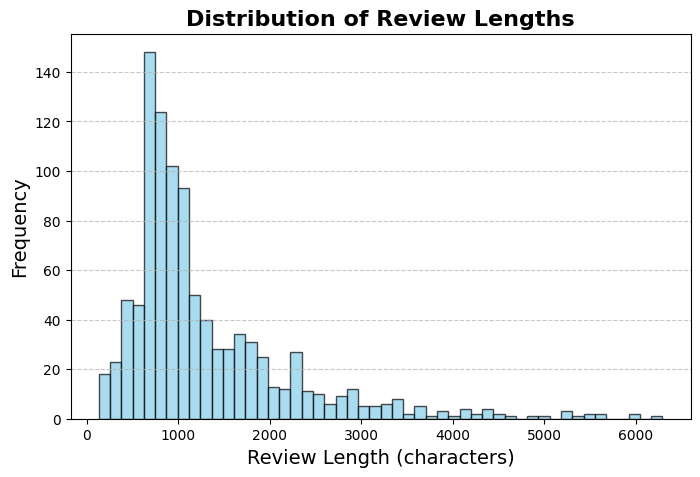

In [6]:
review_lengths = [len(review) for review in review_dataset["train"]["text"]]

plt.figure(figsize=(8,5))
plt.hist(review_lengths, bins=50, color="skyblue", edgecolor="black", alpha=0.7)

plt.title("Distribution of Review Lengths", fontsize=16, weight="bold")
plt.xlabel("Review Length (characters)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


**DistilBERT** is a base model, which is smaller and faster version of BERT. 
- Designed mainly for general-purpose NLP tasks like classification, sentiment analysis and sequence labeling.
- It uses subword-level tokenization, same as BERT.

In [7]:
model_checkpoint = 'distilbert-base-uncased'

id2target = {0: "Negative", 1: "Positive"}
target2id = {v: k for k, v in id2target.items()}

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(id2target),
    id2label=id2target,
    label2id=target2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = review_dataset.map(tokenize_function, batched=True)

In [12]:
accuracy = evaluate.load("accuracy")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy.compute(predictions=preds, references=p.label_ids)

**Base Model performance**

In [13]:
test_reviews = [
    "It was good.", 
    "Not a fan, don't recommend.",
    "Better than the first one.",
    "This is not worth watching even once.",
    "This one is a pass.",
    "Absolutely loved it!",
    "Terrible, I regret watching.",
    "Just okay, nothing special.",
    "Surprisingly fun to watch.",
    "I couldn’t finish it, too boring.",
    "Well acted, but the story was weak.",
    "A solid sequel, much better paced.",
    "Completely forgettable.",
    "One of the best I’ve seen this year.",
    "Not bad, but not great either.",
    "Painfully slow, don’t waste your time.",
    "An enjoyable experience overall.",
    "It felt rushed and unfinished.",
    "Worth watching at least once.",
    "I laughed more than I expected."
]

for text in test_reviews:
    inputs = tokenizer.encode(text, return_tensors="pt")
    logits = model(inputs).logits
    predictions = torch.argmax(logits)

    print(text + " - " + id2target[predictions.tolist()])
    

It was good. - Positive
Not a fan, don't recommend. - Positive
Better than the first one. - Positive
This is not worth watching even once. - Positive
This one is a pass. - Positive
Absolutely loved it! - Positive
Terrible, I regret watching. - Positive
Just okay, nothing special. - Positive
Surprisingly fun to watch. - Positive
I couldn’t finish it, too boring. - Positive
Well acted, but the story was weak. - Positive
A solid sequel, much better paced. - Positive
Completely forgettable. - Positive
One of the best I’ve seen this year. - Positive
Not bad, but not great either. - Positive
Painfully slow, don’t waste your time. - Positive
An enjoyable experience overall. - Positive
It felt rushed and unfinished. - Positive
Worth watching at least once. - Positive
I laughed more than I expected. - Positive


**LoRA (Low-Rank Adaptation of Large Language Models):** LoRA is a parameter-efficient fine-tuning method. Instead of updating all model weights (which likely corresponds to a huge computation), it injects small trainable low-rank matrices into some layers, while keeping original weight frozen.

In [14]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                         r=4,
                         lora_alpha=32,
                         lora_dropout=0.1,
                         target_modules=["q_lin"])

In [15]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9307


- As seen above, less than %1 of parameters will be updated rather than all >67M.

In [16]:
lr = 1e-3
batch_size = 4
num_epochs = 10

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    num_train_epochs=num_epochs,
)


In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

C:\Users\ereno\AppData\Local\Temp\ipykernel_5592\2730382648.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
trainer.train()

Step,Training Loss
500,0.424900
1000,0.188200
1500,0.060700
2000,0.025100
2500,0.009800


TrainOutput(global_step=2500, training_loss=0.1417525728225708, metrics={'train_runtime': 577.6114, 'train_samples_per_second': 17.313, 'train_steps_per_second': 4.328, 'total_flos': 1343996682240000.0, 'train_loss': 0.1417525728225708, 'epoch': 10.0})

**Final Model Performance**

In [19]:
model.to('cpu')

for text in test_reviews:
    inputs = tokenizer.encode(text, return_tensors="pt")
    logits = model(inputs).logits
    predictions = torch.max(logits, 1).indices
    #predictions = torch.argmax(logits)

    print(text + " - " + id2target[predictions.tolist()[0]])

It was good. - Positive
Not a fan, don't recommend. - Negative
Better than the first one. - Positive
This is not worth watching even once. - Negative
This one is a pass. - Negative
Absolutely loved it! - Positive
Terrible, I regret watching. - Negative
Just okay, nothing special. - Negative
Surprisingly fun to watch. - Positive
I couldn’t finish it, too boring. - Negative
Well acted, but the story was weak. - Negative
A solid sequel, much better paced. - Positive
Completely forgettable. - Negative
One of the best I’ve seen this year. - Positive
Not bad, but not great either. - Positive
Painfully slow, don’t waste your time. - Positive
An enjoyable experience overall. - Positive
It felt rushed and unfinished. - Negative
Worth watching at least once. - Positive
I laughed more than I expected. - Negative
